In [177]:
# 라이브러리 모음

import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
import copy 
import os 
import torch
import numpy as np
import cv2
import os
import zipfile


from torchvision.models import resnet18, resnet34, resnet50

from PIL import Image 
from torch.utils.data import Dataset 
import torchvision
import torchvision.transforms as transforms 
from torch.optim.lr_scheduler import ReduceLROnPlateau  
import torch.nn as nn 
from torchvision import utils 
from torchvision.datasets import ImageFolder
from torchsummary import summary
import torch.nn.functional as F
from sklearn.metrics import classification_report
import itertools 
from tqdm.notebook import trange, tqdm 
from torch import optim
import warnings

warnings.filterwarnings('ignore')

In [178]:
IMAGE_SIZE = 256
IMAGE_CHANNEL = 3
EPOCH_18 = 100
EPOCH_34 = 25

In [179]:
def zip_folder(folder_path, output_path):
    # zipfile.ZipFile을 사용하여 zip 파일을 생성합니다.
    with zipfile.ZipFile(output_path, 'w', zipfile.ZIP_DEFLATED) as zip_file:
        # os.walk()를 사용하여 폴더 내의 모든 파일과 폴더를 순회합니다.
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                # 파일의 전체 경로를 가져옵니다.
                file_path = os.path.join(root, file)
                # zip 파일 내의 상대 경로를 계산합니다.
                relative_path = os.path.relpath(file_path, folder_path)
                # zip 파일에 파일을 추가합니다.
                zip_file.write(file_path, relative_path)

In [180]:
class CLAHETransform:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        
    def __call__(self, img):
        img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(img)
        l = self.clahe.apply(l)
        img = cv2.merge((l, a, b))
        img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
        return Image.fromarray(img)

class GammaCorrection:
    def __init__(self, gamma=1.0):
        self.gamma = gamma
        
    def __call__(self, img):
        img = np.array(img)
        img = img / 255.0
        img = np.power(img, self.gamma)
        img = np.uint8(img * 255)
        return Image.fromarray(img)

# 가우시안 분포 이미지를 생성하는 함수
def create_gaussian_mask(size, sigma=0.5):
    """ size: (H, W) 형태의 튜플로 이미지 크기 설정
        sigma: 가우시안 분포의 표준편차
    """
    H, W = size
    # 가우시안 분포를 만드는 x, y 좌표계 생성
    x = np.linspace(-1, 1, W)
    y = np.linspace(-1, 1, H)
    x, y = np.meshgrid(x, y)
    
    # 2차원 가우시안 분포 계산
    d = np.sqrt(x*x + y*y)
    gaussian = np.exp(-d**2 / (2.0 * sigma**2))
    
    return gaussian

# MultiplyTransform 클래스 수정: 가우시안 분포 이미지 곱하기
class GaussianMultiplyTransform:
    def __init__(self, size, sigma=0.5):
        self.gaussian_mask = create_gaussian_mask(size, sigma)
        
    def __call__(self, img):
        img_np = np.array(img).astype(np.float32)
        
        # 가우시안 마스크를 채널에 맞게 확장
        gaussian_mask = np.expand_dims(self.gaussian_mask, axis=-1)
        gaussian_mask = np.repeat(gaussian_mask, img_np.shape[-1], axis=-1)
        
        # 이미지에 가우시안 마스크 곱하기
        img_np *= gaussian_mask
        
        # 이미지를 다시 uint8로 변환
        img_np = np.clip(img_np, 0, 255).astype(np.uint8)
        return Image.fromarray(img_np)


In [181]:
transform = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.CenterCrop((IMAGE_SIZE - 20 ,IMAGE_SIZE -20 )),  # // 사용으로 정수 나누기
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                
        CLAHETransform(clip_limit=5.0, tile_grid_size=(8, 8)),
        GammaCorrection(gamma=0.45),
        GaussianMultiplyTransform(size=(IMAGE_SIZE, IMAGE_SIZE), sigma=0.8),  # 가우시안 분포 곱하기
        
        
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [182]:
# Define object of the Train, Validation, and Test dataset.
train_set = torchvision.datasets.ImageFolder("archive/train", transform=transform) 
train_set.transform
val_set = torchvision.datasets.ImageFolder("archive/valid", transform=transform)
val_set.transform
test_set = torchvision.datasets.ImageFolder("archive/test", transform=transform)
test_set.transform

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(236, 236))
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

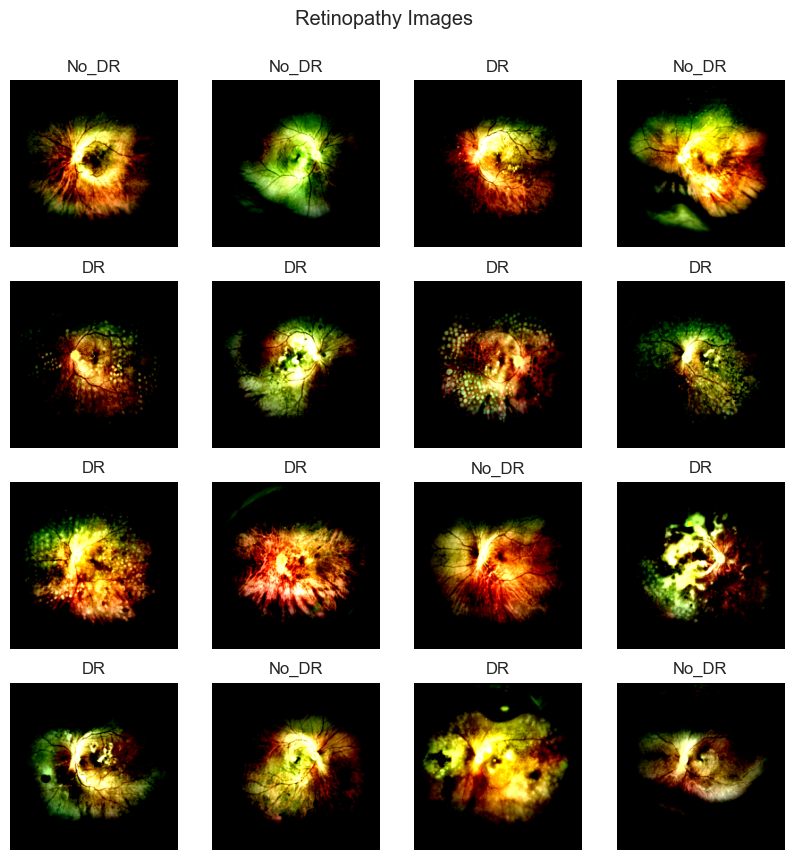

In [183]:
# Visualizing some images from Trainset
CLA_label = {
        0 : 'DR',
        1 : 'No_DR',
}
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(CLA_label[label])
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    # Clip pixel values to [0, 1]
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    plt.suptitle('Retinopathy Images', y=0.95)
plt.show()

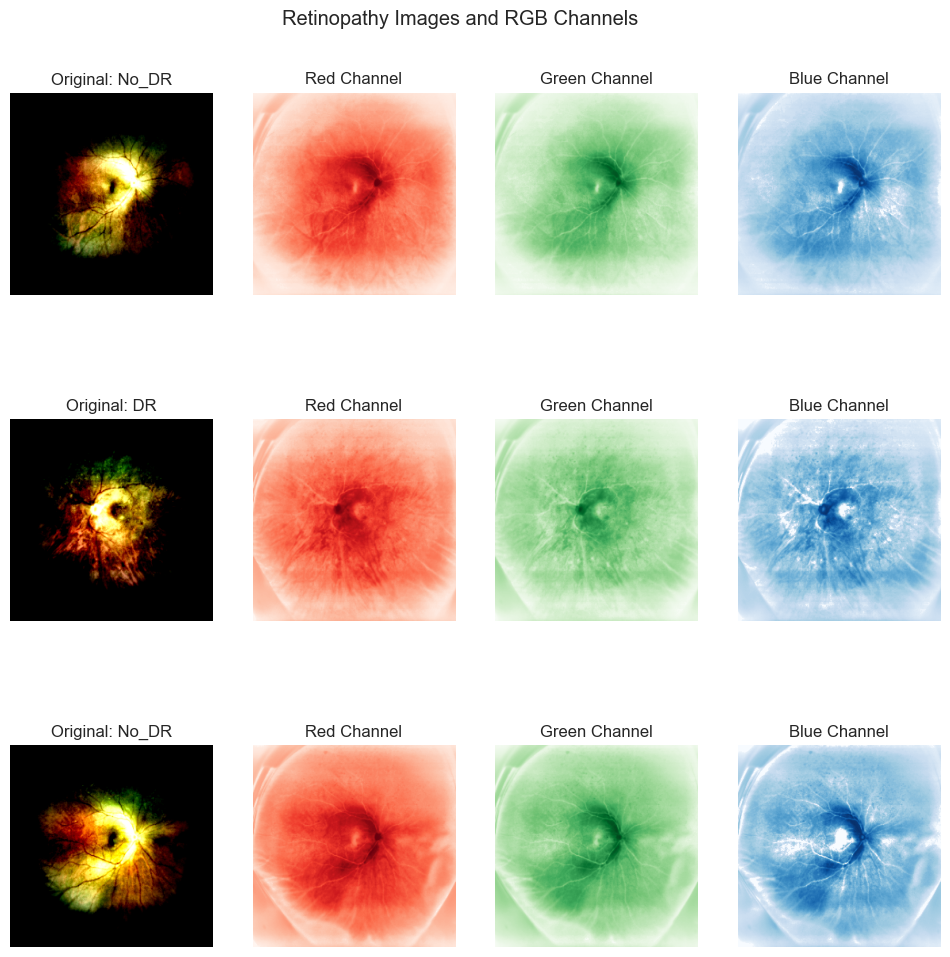

In [184]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 그리드 크기 설정
rows, cols = 3, 4

# 이미지 그리드 설정
figure = plt.figure(figsize=(12, 12))

for row in range(1, rows + 1):
    # 무작위로 이미지 선택
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    
    # 이미지 numpy 배열로 변환
    img_np = img.numpy().transpose((1, 2, 0))

    # 이미지 RGB 채널 분리
    R = img_np[:, :, 0]
    G = img_np[:, :, 1]
    B = img_np[:, :, 2]

    # 각 채널 및 원본 이미지를 시각화
    figure.add_subplot(rows, cols, (row - 1) * cols + 1)
    plt.title(f"Original: {CLA_label[label]}")
    plt.axis("off")
    plt.imshow(np.clip(img_np, 0, 1))

    figure.add_subplot(rows, cols, (row - 1) * cols + 2)
    plt.title("Red Channel")
    plt.axis("off")
    plt.imshow(R, cmap="Reds")

    figure.add_subplot(rows, cols, (row - 1) * cols + 3)
    plt.title("Green Channel")
    plt.axis("off")
    plt.imshow(G, cmap="Greens")

    figure.add_subplot(rows, cols, (row - 1) * cols + 4)
    plt.title("Blue Channel")
    plt.axis("off")
    plt.imshow(B, cmap="Blues")

plt.suptitle('Retinopathy Images and RGB Channels', y=0.92)
plt.show()


In [185]:
# Import and load Train, Validation and Test set
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = True)

In [186]:
# Print shape of Dataset
for key, value in {'Training data': train_loader, "Validation data": val_loader,"Test data": test_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

Training data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64

Validation data:
Shape of X : torch.Size([8, 3, 256, 256])
Shape of y: torch.Size([8]) torch.int64

Test data:
Shape of X : torch.Size([6, 3, 256, 256])
Shape of y: torch.Size([6]) torch.int64



In [187]:
# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']
        
# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):
    
    loss = loss_func(output, target) # get loss
    pred = output.argmax(dim=1, keepdim=True) # Get Output Class
    metric_b=pred.eq(target.view_as(pred)).sum().item() # get performance metric
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

#model이 인셉션일때
def loss_batch(loss_func, output, target, opt=None):
    # Inception 모델의 경우 logits을 추출
    if isinstance(output, (tuple, list)):
        output = output[0]  # output이 튜플이나 리스트인 경우 첫 번째 요소 추출
    
    if hasattr(output, 'logits'):
        output = output.logits

    loss = loss_func(output, target)  # 손실 계산
    pred = output.argmax(dim=1, keepdim=True)  # 예측된 클래스
    metric_b = pred.eq(target.view_as(pred)).sum().item()  # 성능 지표 계산
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b


# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,opt=None):
    
    run_loss=0.0 
    t_metric=0.0
    len_data=len(dataset_dl.dataset)

    # internal loop over dataset
    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) # get model output
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # get loss per batch
        run_loss+=loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric+=metric_b    
    
    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value
    
    return loss, metric

def train_val(model, params, verbose=False):
    
    # Get the parameters
    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimiser"]
    train_dl=params["train"]
    val_dl=params["val"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]
    
    # history of loss values in each epoch
    loss_history={"train": [],"val": []} 
    # histroy of metric values in each epoch
    metric_history={"train": [],"val": []} 
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict()) 
    # initialize best loss to a large value
    best_loss=float('inf') 

# Train Model n_epochs (the progress of training by printing the epoch number and the associated learning rate. It can be helpful for debugging, monitoring the learning rate schedule, or gaining insights into the training process.) 
    
    for epoch in tqdm(range(epochs)):
        # Get the Learning Rate
        current_lr=get_lr(opt)
        if(verbose):
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))
# Train Model Process
        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,opt)

        # collect losses
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
# Evaluate Model Process
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl)
        
        # store best model
        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*10) 

    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history
def get_params(EPOCH):
    return {
        "train": train_loader,"val": val_loader,
        "epochs": EPOCH,
        "optimiser": optim.Adam(Retino_model.parameters(),lr=1e-4),
        "lr_change": ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1),
        "f_loss": nn.NLLLoss(reduction="sum"),
        "weight_path": "weights.pt",
        }

def create_resnet_model(num_classes, model_name):
    if model_name == 'resnet18':
        model = resnet18(pretrained=True)
    elif model_name == 'resnet34':
        model = resnet34(pretrained=True)
    elif model_name == 'resnet50':
        model = resnet50(pretrained=True)
    elif model_name == 'inception_v3':
        model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
    elif model_name == 'googlenet':
        model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)

    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    return model

In [188]:
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve

# 모델 평가 함수
def evaluate_model(model, data_loader, device):

    # Convergence History Plot
    epochs=params_train["epochs"]
    fig,ax = plt.subplots(1,2,figsize=(12,5))

    sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist_m["train"],ax=ax[0],label='loss_hist["train"]')
    sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist_m["val"],ax=ax[0],label='loss_hist["val"]')
    sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist_m["train"],ax=ax[1],label='Acc_hist["train"]')
    sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist_m["val"],ax=ax[1],label='Acc_hist["val"]')

    plt.title(f"{Retino_model.__class__.__name__} Loss-Acc")
    
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for xb, yb in data_loader:
            xb, yb = xb.to(device), yb.to(device)
            output = model(xb)
            probs = torch.exp(output)
            preds = probs.argmax(dim=1)
            all_labels.extend(yb.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of the positive class

    accuracy = accuracy_score(all_labels, all_preds)
    auroc = roc_auc_score(all_labels, all_probs)
    auprc = average_precision_score(all_labels, all_probs)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUROC: {auroc:.4f}")
    print(f"AUPRC: {auprc:.4f}")

    # ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"AUROC: {auroc:.4f}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(all_labels, all_probs)
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f"AUPRC: {auprc:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="lower left")

    plt.tight_layout()
    plt.show()

    return accuracy, auroc, auprc, all_labels, all_preds, all_probs



In [189]:
# 모델 생성
Retino_model = create_resnet_model(num_classes=2, model_name='resnet18')
loss_func = nn.NLLLoss(reduction="sum")
opt = optim.Adam(Retino_model.parameters(), lr=1e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)


if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')


Retino_model = Retino_model.to(device)
params_train=get_params(EPOCH_18)
print(Retino_model.__class__.__name__)
# Model Summary for ResNet
# summary(Retino_model, input_size=(IMAGE_CHANNEL, IMAGE_SIZE, IMAGE_SIZE), device=device.type)
# 모델 평가
model,loss_hist_m,metric_hist_m = train_val(Retino_model,params_train)

accuracy, auroc, auprc, all_labels, all_preds, all_probs = evaluate_model(model, test_loader, device)
torch.save(model.state_dict(), "resnet18/model_weights.pth")

# 사용 예제
folder_to_zip = 'resnet18'
if device == 'mps':
    output_zip_file = '/Users/kite/Library/CloudStorage/GoogleDrive-parkite576@gmail.com/내 드라이브/연구실 자료 LAB/UWF4DR/resnet18.zip'
else:
    output_zip_file = 'resnet18.zip'

zip_folder(folder_to_zip, output_zip_file)

ResNet


  0%|          | 0/100 [00:00<?, ?it/s]

ResNet


  0%|          | 0/30 [00:00<?, ?it/s]

Accuracy: 1.0000
AUROC: 1.0000
AUPRC: 1.0000


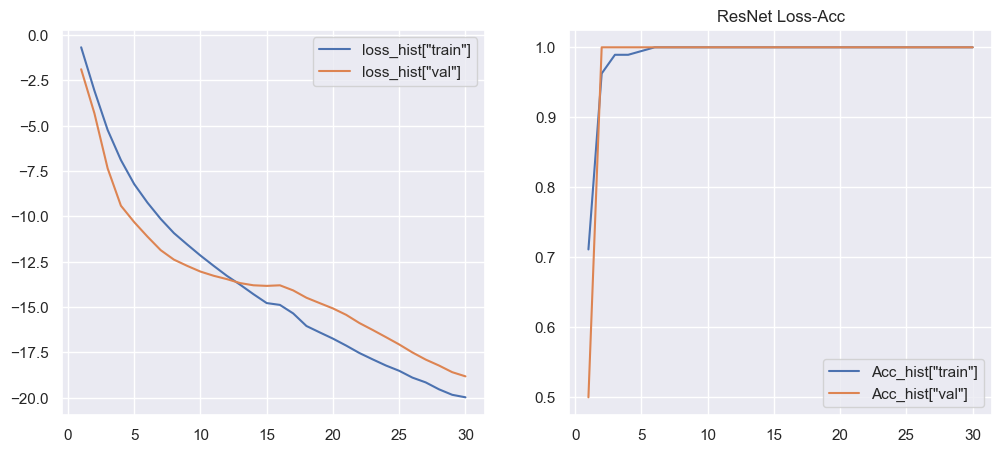

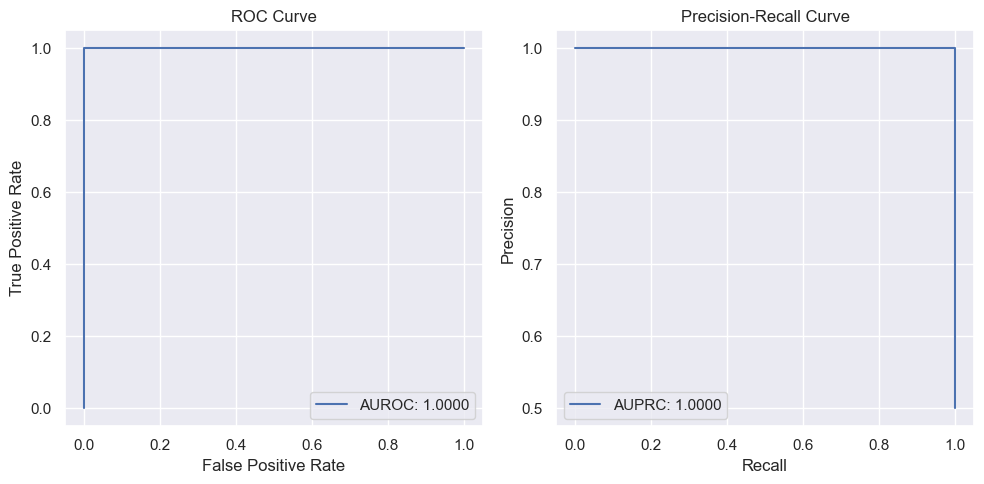

In [ ]:
# 모델 생성
Retino_model = create_resnet_model(num_classes=2, model_name='resnet34')

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')


Retino_model = Retino_model.to(device)

params_train=get_params(EPOCH_34)
print(Retino_model.__class__.__name__)
# Model Summary for ResNet
# summary(Retino_model, input_size=(IMAGE_CHANNEL, IMAGE_SIZE, IMAGE_SIZE), device=device.type)
# summary(Retino_model, input_size=(3, 299, 299), device=device.type)
loss_func = nn.NLLLoss(reduction="sum")
opt = optim.Adam(Retino_model.parameters(), lr=1e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)
model,loss_hist_m,metric_hist_m = train_val(Retino_model,params_train)

accuracy, auroc, auprc, all_labels, all_preds, all_probs = evaluate_model(model, test_loader, device)
torch.save(model.state_dict(), "resnet34/model_weights.pth")

folder_to_zip = 'resnet34'


if device == 'mps':
    output_zip_file = '/Users/kite/Library/CloudStorage/GoogleDrive-parkite576@gmail.com/내 드라이브/연구실 자료 LAB/UWF4DR/resnet34.zip'
else:
    output_zip_file = 'resnet34.zip'

zip_folder(folder_to_zip, output_zip_file)

In [ ]:
print(device)

mps


In [ ]:
# # 모델 생성
# Retino_model = create_resnet_model(num_classes=2, model_name='resnet50')

# if torch.cuda.is_available():
#     device = torch.device('cuda')
# elif torch.backends.mps.is_available():
#     device = torch.device('mps')
# else:
#     device = torch.device('cpu')


# Retino_model = Retino_model.to(device)
# params_train=get_params()



# print(Retino_model.__class__.__name__)
# # Model Summary for ResNet
# summary(Retino_model, input_size=(IMAGE_CHANNEL, IMAGE_SIZE, IMAGE_SIZE), device=device.type)
# # summary(Retino_model, input_size=(3, 299, 299), device=device.type)
# loss_func = nn.NLLLoss(reduction="sum")
# opt = optim.Adam(Retino_model.parameters(), lr=1e-4)
# lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)
# model,loss_hist_m,metric_hist_m = train_val(Retino_model,params_train)


# accuracy, auroc, auprc, all_labels, all_preds, all_probs = evaluate_model(model, test_loader, device)
# torch.save(model.state_dict(), "resnet50/model_weights.pth")

In [ ]:
# # 모델 생성
# Retino_model = create_resnet_model(num_classes=2, model_name='inception_v3')
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Retino_model = Retino_model.to(device)
# print(Retino_model.__class__.__name__)
# # Model Summary for ResNet
# summary(Retino_model, input_size=(3, 255, 255), device=device.type)
# # summary(Retino_model, input_size=(3, 299, 299), device=device.type)
# loss_func = nn.NLLLoss(reduction="sum")
# opt = optim.Adam(Retino_model.parameters(), lr=1e-4)
# lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)
# model,loss_hist_m,metric_hist_m = train_val(Retino_model,params_train)

# accuracy, auroc, auprc, all_labels, all_preds, all_probs = evaluate_model(model, test_loader, device)
# torch.save(model.state_dict(), "inception/model_weights.pth")

In [ ]:
# # 모델 생성
# Retino_model = create_resnet_model(num_classes=2, model_name='googlenet')
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Retino_model = Retino_model.to(device)
# print(Retino_model.__class__.__name__)
# # Model Summary for ResNet
# summary(Retino_model, input_size=(3, 255, 255), device=device.type)
# # summary(Retino_model, input_size=(3, 299, 299), device=device.type)
# loss_func = nn.NLLLoss(reduction="sum")
# opt = optim.Adam(Retino_model.parameters(), lr=1e-4)
# lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)
# model,loss_hist_m,metric_hist_m = train_val(Retino_model,params_train)

# accuracy, auroc, auprc, all_labels, all_preds, all_probs = evaluate_model(model, test_loader, device)
# torch.save(model.state_dict(), "google/model_weights.pth")